# 0. Now we have chose FoodVision from PyTorvh torchvision to work with

We need to:
1. Prepare our data from torch vision
2. Build a model( we will use pre-build model to make comparison)
    * 1. Choose an optimizer and loss function
    * 2. Design a training and testing loop
3. Fit the model to the data and make a prediction
4. Evaluate the model
5. Improve through experiment
6. Save model

## 1. Prepare our data

We are going to use this Food101 as our data: https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html

Plan:
Download the data and split into 2 version
* 1st version: Every classes has only 100 photo
* 2nd version: Every classes has complete 1000 photo

In this way, we can simply use the 1st version  of the data to evaluate which model are best suit to our data

In [6]:
# Download data
from pathlib import Path
import torch as T
import torchvision


image_path = Path("data/")
image_data = image_path / "Food"

if image_data.is_dir():
    print(f"File existed. Skipping Download...")
else:
    train_data = torchvision.datasets.Food101(root=image_data,
                                              split="train",
                                              download=True)
    test_data = torchvision.datasets.Food101(root=image_data,
                                             split="test",
                                             download=True)


File existed. Skipping Download...


In [11]:
# Check if train and test data is downloaded perfectly
print(f"length of train data: {len(train_data)}")
print(f"length of test_data: {len(test_data)}")
print(f"number of classes: {len(train_data.classes)}")

length of train data: 75750
length of test_data: 25250
number of classes: 101


In [29]:
train_data

Dataset Food101
    Number of datapoints: 75750
    Root location: data\Food
    split=train

In [13]:
# set classes
class_names = train_data.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

hot_dog


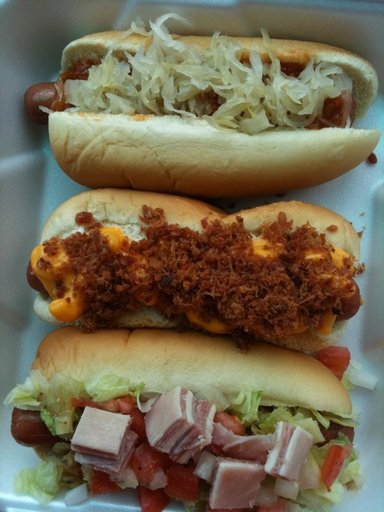

In [54]:
# Print out random immage

import random
random_idx = random.randint(0,len(train_data)-1)

print(class_names[train_data[random_idx][1]])
train_data[random_idx][0]

In [66]:
# Now we split the data in 10%
# Get random 10% of training images
import random

# Setup data paths
data_path = image_path /"Food" / "food-101" / "images"

# Change amount of data to get (e.g. 0.1 = random 10%, 0.2 = random 20%)
amount_to_get = 0.1

# Create function to separate a random amount of data
def get_subset(image_path=data_path,
               data_splits=["train", "test"], 
               target_classes=class_names,
               amount=0.1,
               seed=42):
    random.seed(42)
    label_splits = {}
    
    # Get labels
    for data_split in data_splits:
        print(f"[INFO] Creating image split for: {data_split}...")
        label_path = image_data / "food-101" / "meta" /  f"{data_split}.txt"
        with open(label_path, "r") as f:
            labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes] 
        
        # Get random subset of target classes image ID's
        number_to_sample = round(amount * len(labels))
        print(f"[INFO] Getting random subset of {number_to_sample} images for {data_split}...")
        sampled_images = random.sample(labels, k=number_to_sample)
        
        # Apply full paths
        image_paths = [Path(str(image_path / sample_image) + ".jpg") for sample_image in sampled_images]
        label_splits[data_split] = image_paths
    return label_splits
        
label_splits = get_subset(amount=amount_to_get)
label_splits["train"][:10]

[INFO] Creating image split for: train...
[INFO] Getting random subset of 7575 images for train...
[INFO] Creating image split for: test...
[INFO] Getting random subset of 2525 images for test...


[WindowsPath('data/Food/food-101/images/chicken_quesadilla/2670687.jpg'),
 WindowsPath('data/Food/food-101/images/beef_tartare/2507172.jpg'),
 WindowsPath('data/Food/food-101/images/greek_salad/1260996.jpg'),
 WindowsPath('data/Food/food-101/images/french_toast/3917826.jpg'),
 WindowsPath('data/Food/food-101/images/foie_gras/1035427.jpg'),
 WindowsPath('data/Food/food-101/images/clam_chowder/2402986.jpg'),
 WindowsPath('data/Food/food-101/images/cheese_plate/75029.jpg'),
 WindowsPath('data/Food/food-101/images/sushi/2019344.jpg'),
 WindowsPath('data/Food/food-101/images/ceviche/1648055.jpg'),
 WindowsPath('data/Food/food-101/images/panna_cotta/357026.jpg')]

In [69]:
# Create target directory path
target_dir_name = f"../ML_learning/data/food_{str(int(amount_to_get*100))}_percent"
print(f"Creating directory: '{target_dir_name}'")

# Setup the directories
target_dir = Path(target_dir_name)

# Make the directories
target_dir.mkdir(parents=True, exist_ok=True)

Creating directory: '../ML_learning/data/food_10_percent'


In [68]:
import shutil

for image_split in label_splits.keys():
    for image_path in label_splits[str(image_split)]:
        dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
        if not dest_dir.parent.is_dir():
            dest_dir.parent.mkdir(parents=True, exist_ok=True)
        print(f"[INFO] Copying {image_path} to {dest_dir}...")
        shutil.copy2(image_path, dest_dir)

[INFO] Copying data\Food\food-101\images\chicken_quesadilla\2670687.jpg to ..\data\food_10_percent\train\chicken_quesadilla\2670687.jpg...
[INFO] Copying data\Food\food-101\images\beef_tartare\2507172.jpg to ..\data\food_10_percent\train\beef_tartare\2507172.jpg...
[INFO] Copying data\Food\food-101\images\greek_salad\1260996.jpg to ..\data\food_10_percent\train\greek_salad\1260996.jpg...
[INFO] Copying data\Food\food-101\images\french_toast\3917826.jpg to ..\data\food_10_percent\train\french_toast\3917826.jpg...
[INFO] Copying data\Food\food-101\images\foie_gras\1035427.jpg to ..\data\food_10_percent\train\foie_gras\1035427.jpg...
[INFO] Copying data\Food\food-101\images\clam_chowder\2402986.jpg to ..\data\food_10_percent\train\clam_chowder\2402986.jpg...
[INFO] Copying data\Food\food-101\images\cheese_plate\75029.jpg to ..\data\food_10_percent\train\cheese_plate\75029.jpg...
[INFO] Copying data\Food\food-101\images\sushi\2019344.jpg to ..\data\food_10_percent\train\sushi\2019344.jpg..

Let's translate it into a python scripts in scripts
